In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"merlijnvanengelen","key":"59d2edcb1d0b8088281e7ed626695646"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats

100% 810M/812M [00:07<00:00, 113MB/s]
100% 812M/812M [00:07<00:00, 116MB/s]


In [ ]:
!unzip -qq dogs-vs-cats.zip

In [ ]:
!unzip -qq train.zip

**Listing 8.6 Copying images to training, validation, and test directories**

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
      dir = new_base_dir / subset_name / category
      os.makedirs(dir)
      fnames = [f"{category}.{i}.jpg"
                for i in range(start_index, end_index)]
      for fname in fnames:
        shutil.copyfile(src=original_dir / fname,
                                 dst=dir / fname)
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32
)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


**Listing 8.19 Instantiating the VGG16 convolutional base**

In [ ]:
from tensorflow import keras

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3)
)
conv_base.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                              

**Listing 8.19 Instantiating the VGG16 convolutional base**

In [ ]:
import numpy as np

def get_features_and_labels(dataset):
  all_features = []
  all_labels = []
  for images, labels in dataset:
    print('Processing images/labels...')
    preprocessed_images = keras.applications.vgg16.preprocess_input(images)
    print('Extracting features...')
    features = conv_base.predict(preprocessed_images)
    all_features.append(features)
    all_labels.append(labels)
  return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
print('Doing val_dataset')
val_features, val_labels = get_features_and_labels(validation_dataset)
print('Doing test_dataset')
test_features, test_labels = get_features_and_labels(test_dataset)

train_features.shape

Processing images/labels...
Extracting features...
1/1 [==============================] - 0s 31ms/step
Processing images/labels...
Extracting features...
1/1 [==============================] - 0s 35ms/step
Processing images/labels...
Extracting features...
1/1 [==============================] - 0s 43ms/step
Processing images/labels...
Extracting features...
1/1 [==============================] - 0s 32ms/step
Processing images/labels...
Extracting features...
1/1 [==============================] - 0s 29ms/step
Processing images/labels...
Extracting features...
1/1 [==============================] - 0s 40ms/step
Processing images/labels...
Extracting features...
1/1 [==============================] - 0s 25ms/step
Processing images/labels...
Extracting features...
1/1 [==============================] - 0s 28ms/step
Processing images/labels...
Extracting features...
1/1 [==============================] - 0s 36ms/step
Processing images/labels...
Extracting features...
1/1 [=================

(2000, 5, 5, 512)

In [ ]:
print(len(train_features), len(train_labels))

2000 2000


**Listing 8.21 Defining and training the densely connected classifier**

In [ ]:
from tensorflow.keras import layers

inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)
print("Compiling model...")
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks
)

Compiling model...
Epoch 1/20
63/63 [==============================] - 3s 16ms/step - loss: 29.9885 - accuracy: 0.9160 - val_loss: 3.9399 - val_accuracy: 0.9650
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 5.1907 - accuracy: 0.9735 - val_loss: 10.4158 - val_accuracy: 0.9550
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 2.0273 - accuracy: 0.9840 - val_loss: 8.1616 - val_accuracy: 0.9600
Epoch 4/20
63/63 [==============================] - 0s 8ms/step - loss: 0.9239 - accuracy: 0.9910 - val_loss: 4.9766 - val_accuracy: 0.9720
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 0.7988 - accuracy: 0.9900 - val_loss: 5.7687 - val_accuracy: 0.9680
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 0.3066 - accuracy: 0.9980 - val_loss: 4.7752 - val_accuracy: 0.9750
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 0.3236 - accuracy: 0.9960 - val_loss: 4.9587 - val_accuracy: 0.975

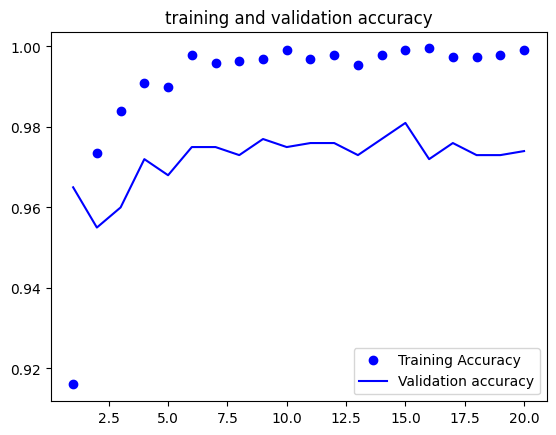

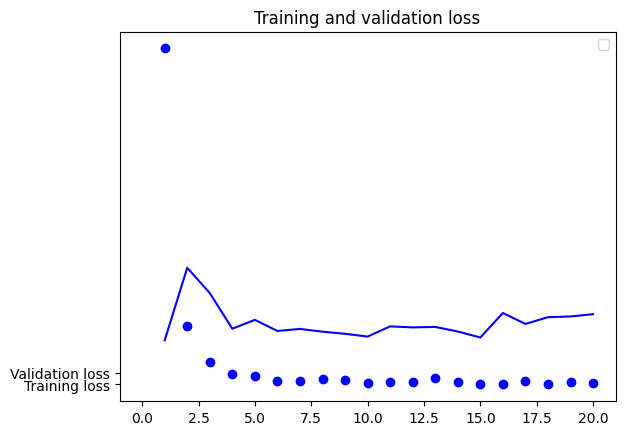

In [ ]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training Accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", "Training loss")
plt.plot(epochs, val_loss, "b", "Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Listing 8.23 Instantiating and freezing the VGG16 convolutional base**

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**Listing 8.24 Printing the list of trainable weights before and after freezing**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
        train_dataset,
        epochs=50,
        validation_data=validation_dataset,
        callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 11s 144ms/step - loss: 18.2927 - accuracy: 0.8965 - val_loss: 3.2446 - val_accuracy: 0.9750
Epoch 2/50
63/63 [==============================] - 9s 140ms/step - loss: 7.5124 - accuracy: 0.9465 - val_loss: 7.2225 - val_accuracy: 0.9620
Epoch 3/50
63/63 [==============================] - 9s 140ms/step - loss: 5.5984 - accuracy: 0.9510 - val_loss: 15.1222 - val_accuracy: 0.9250
Epoch 4/50
63/63 [==============================] - 9s 138ms/step - loss: 4.9689 - accuracy: 0.9555 - val_loss: 5.7017 - val_accuracy: 0.9710
Epoch 5/50
63/63 [==============================] - 9s 140ms/step - loss: 5.2498 - accuracy: 0.9625 - val_loss: 5.5589 - val_accuracy: 0.9740
Epoch 6/50
63/63 [==============================] - 9s 145ms/step - loss: 3.2497 - accuracy: 0.9710 - val_loss: 3.4249 - val_accuracy: 0.9740
Epoch 7/50
63/63 [==============================] - 9s 140ms/step - loss: 3.8428 - accuracy: 0.9665 - val_loss: 5.3053 - val_accuracy: 0.9680
Epo

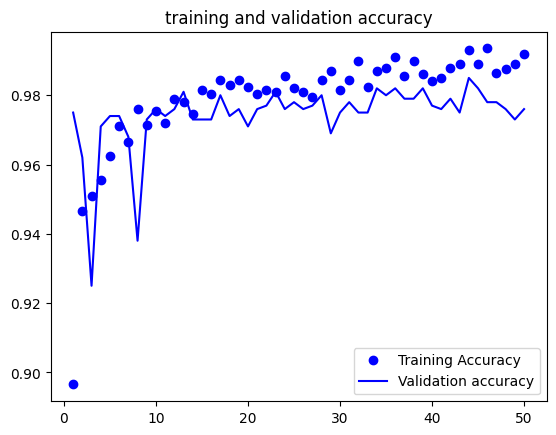

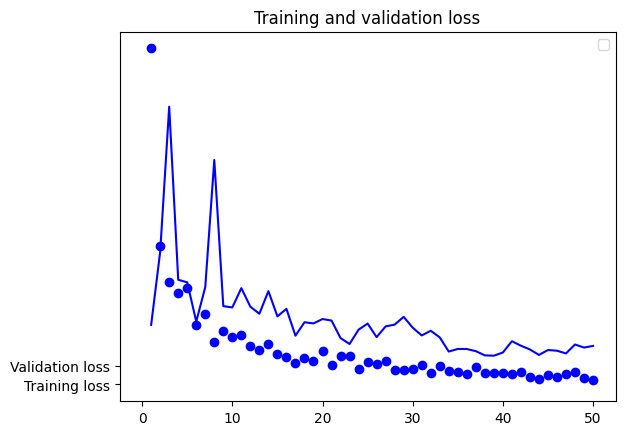

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training Accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", "Training loss")
plt.plot(epochs, val_loss, "b", "Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 6s 88ms/step - loss: 1.9377 - accuracy: 0.9765
Test accuracy: 0.976


**Listing 8.27 Freezing all layers until the fourth from the last**

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Listing 8.28 Fine-tuning the model**

In [ ]:
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.RMSprop(learning_rate=1e-5), metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)


Epoch 1/30
63/63 [==============================] - 14s 164ms/step - loss: 0.4422 - accuracy: 0.9890 - val_loss: 1.9426 - val_accuracy: 0.9760
Epoch 2/30
63/63 [==============================] - 10s 160ms/step - loss: 0.3561 - accuracy: 0.9930 - val_loss: 1.3550 - val_accuracy: 0.9800
Epoch 3/30
63/63 [==============================] - 11s 166ms/step - loss: 0.3444 - accuracy: 0.9915 - val_loss: 1.5059 - val_accuracy: 0.9770
Epoch 4/30
63/63 [==============================] - 12s 189ms/step - loss: 0.3663 - accuracy: 0.9910 - val_loss: 1.4248 - val_accuracy: 0.9800
Epoch 5/30
63/63 [==============================] - 12s 188ms/step - loss: 0.3045 - accuracy: 0.9915 - val_loss: 1.5087 - val_accuracy: 0.9780
Epoch 6/30
63/63 [==============================] - 10s 158ms/step - loss: 0.2353 - accuracy: 0.9920 - val_loss: 1.8894 - val_accuracy: 0.9720
Epoch 7/30
63/63 [==============================] - 10s 160ms/step - loss: 0.2316 - accuracy: 0.9940 - val_loss: 2.1298 - val_accuracy: 0.9720

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 6s 90ms/step - loss: 1.5838 - accuracy: 0.9775
Test accuracy: 0.978
